In [ ]:
###############################################################################
############### Term Project - Dog & Cat Classification #######################
######################### Author - Siyuan Liu #################################
########################### March 2022 ########################################

In [ ]:
#https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/overview

In [ ]:
# Helper libraries
import os 
import numpy as np
import tensorflow as tf
import time
import pandas as pd  # data frame operations  
import numpy as np  # arrays and math functions
import matplotlib.pyplot as plt  # static plotting
import re # regular expressions
import scipy
import os # Operation System
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib.backends.backend_pdf import PdfPages
import sklearn
import tensorflow as tf
from datetime import datetime
import cv2
import seaborn as sns


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
#from plot_keras_history import plot_history

In [ ]:
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)


This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [ ]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

#Load the data

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition/data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import zipfile
train_file = "/content/gdrive/MyDrive/458_AI/A4/train.zip"
with zipfile.ZipFile(train_file, 'r') as z:
    z.extractall()

test_file = "/content/gdrive/MyDrive/458_AI/A4/test.zip"
with zipfile.ZipFile(test_file, 'r') as z:
    z.extractall()

z.close()

In [ ]:
base_dir = "/content"
train_dir = os.path.join(base_dir, 'train')
train_img_names = os.listdir(train_dir)

test_dir = os.path.join(base_dir, 'test') 
test_img_names = os.listdir(test_dir)

In [ ]:
train_img_names[:10]

['cat.5112.jpg',
 'dog.9490.jpg',
 'cat.4022.jpg',
 'dog.4205.jpg',
 'dog.12457.jpg',
 'cat.1883.jpg',
 'dog.11463.jpg',
 'dog.1499.jpg',
 'dog.8531.jpg',
 'dog.5234.jpg']

In [ ]:
test_img_names[:10]

['2974.jpg',
 '7933.jpg',
 '3871.jpg',
 '9727.jpg',
 '7508.jpg',
 '10655.jpg',
 '6044.jpg',
 '4189.jpg',
 '9478.jpg',
 '1174.jpg']

In [ ]:
print('total train images :', len(train_img_names ))
print('total test images :', len(test_img_names ))

total train images : 25000
total test images : 12500


In [ ]:
# Sorting of file names facilitated by
def tryint(s):
    try:
        return int(s)
    except:
        return s

def alphanum_key(s):
    """ Turn a string into a list of string and number chunks.
        "z23a" -> ["z", 23, "a"]
    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def sort_nicely(l):
    """ Sort the given list in the way that humans expect.
    """
    l.sort(key=alphanum_key)
    
# Generate list of file names, excluding hidden files    
def directory_list (dir_name):
    start_list = os.listdir(dir_name)
    end_list = []
    for file in start_list:
        if (not file.startswith('.')):
            end_list.append(file) 
    end_list.sort(key = alphanum_key)        
    return(end_list)    

train_ls = directory_list(train_dir)
len(train_ls)
test_ls = directory_list(test_dir)
len(test_ls)

12500

In [ ]:
train_ls[0:5]

['cat.0.jpg', 'cat.1.jpg', 'cat.2.jpg', 'cat.3.jpg', 'cat.4.jpg']

In [ ]:
#split the file name and extract label data
labels = []
for image in train_ls:
    label = image.split(".")[0]
    if label == "dog":
        labels.append("dog")
    else:
        labels.append("cat")
df_train = pd.DataFrame({"Image":train_img_names, "label": labels})

In [ ]:
df_train.head()

,Image,label
0,cat.5112.jpg,cat
1,dog.9490.jpg,cat
2,cat.4022.jpg,cat
3,dog.4205.jpg,cat
4,dog.12457.jpg,cat


#EDA

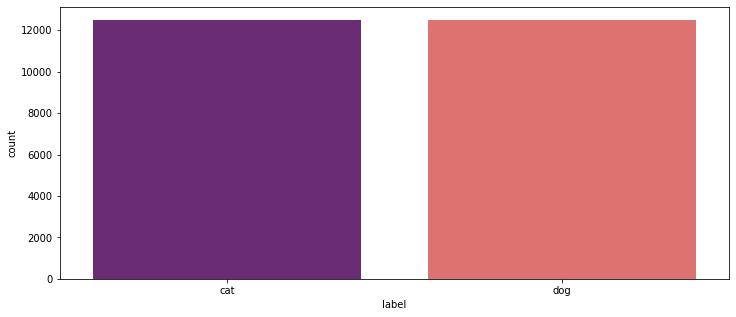

In [ ]:
plt.figure(figsize=(12,5))
sns.countplot(data=df_train, x="label",palette="magma") 

In [ ]:
print(df_train['label'].value_counts())

cat    12500
dog    12500
Name: label, dtype: int64


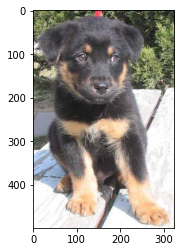

In [ ]:
import random
ran_spl = random.choice(train_img_names)
plt.imshow(plt.imread(("/content/train/"+ran_spl)))

In [ ]:
#image processing functions
def parse_grayscale(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    return(image)
    
def parse_color(image_file_path):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return(image)
  
def parse_grayscale_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    return(image)

def parse_color_and_resize(image_file_path, size = (64, 64)):
    image = cv2.imread(image_file_path, cv2.IMREAD_COLOR)
    # Default cv2 is BGR... need RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, size)
    return(image)  
    
def show_grayscale_image(image):
    plt.imshow(image, cmap = 'gray') 
    plt.axis('off')
    plt.show()

In [ ]:
def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions))))

In [ ]:
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

In [ ]:
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
import errno
outdir = '/content/cats_dogs_arrays'
try:
    os.makedirs(outdir)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

In [ ]:
# Create Numpy Image Arrays
#----------------------------------------------------------------------
print('\nProcessing image files to 64x64 color or grayscale arrays')
# Create train_128_128_3, test_128_128_3 and numpy array for 3000/ 12500 images in color
# train_128_128_3 = np.zeros((25000, 128, 128, 3))  
# for ifile in range(len(train_ls)):
#     image_file_path = os.path.join(train_dir, train_ls[ifile])
#     image = parse_color_and_resize(image_file_path, size = (128, 128))
#     train_128_128_3[ifile,:,:,:] = image    

# test_128_128_3 = np.zeros((12500, 128, 128, 3))  
# for ifile in range(len(test_ls)):
#     image_file_path = os.path.join(test_dir, test_ls[ifile])
#     image = parse_color_and_resize(image_file_path, size = (128, 128))
#     test_128_128_3[ifile,:,:,:] = image    
    
train_64_64_1 = np.zeros((25000, 64, 64, 1))  
for ifile in range(len(train_ls)):
    image_file_path = os.path.join(train_dir, train_ls[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
    train_64_64_1[ifile,:,:,0] = image
    
test_64_64_1 = np.zeros((12500, 64,64, 1))  
for ifile in range(len(test_ls)):
    image_file_path = os.path.join(test_dir, test_ls[ifile])
    image = parse_grayscale_and_resize(image_file_path, size = (64, 64))
    test_64_64_1[ifile,:,:,0] = image
    
# Save numpy array objects for analysis       
# np.save(os.path.join(outdir, 'train_128_128_3.npy'), train_128_128_3)
np.save(os.path.join(outdir, 'train_64_64_1.npy'), train_64_64_1)
# np.save(os.path.join(outdir, 'test_128_128_3.npy'), test_128_128_3)
np.save(os.path.join(outdir, 'test_64_64_1.npy'), test_64_64_1)



Processing image files to 64x64 color or grayscale arrays


In [ ]:
# Global Functions & variables
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
random_seed=9999
from tensorflow.python.framework import ops


#Reset Graphs for Tensorboard
def reset_graph(seed= random_seed):
    ops.reset_default_graph()
    tf.random.set_seed(seed)
    np.random.seed(seed)
    
    
#Save images to working directory
def save_fig(fig_id, tight_layout=True):
    path = os.path.join(work_dir, "images", chp_id, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)
    

#Randomly Sort Batches
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch
        

from matplotlib import pyplot as plt  # for display of images
def show_grayscale_image(image):
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()
    
    
#Check distribtion of test , valid and train
def dist_plot(var1, var2, var3):
    tmp_plt=sns.countplot(var1, palette="Blues").set_title(var2)
    tmp_fig = tmp_plt.get_figure()
    tmp_fig.savefig(var3 + ".png", 
        bbox_inches = 'tight', dpi=None, facecolor='w', edgecolor='b', 
        orientation='portrait', papertype=None, format=None, 
        transparent=True, pad_inches=0.25, frameon=None)
    return(tmp_plt)

Instructions for updating:
non-resource variables are not supported in the long term


#Data Preprocessing & Preparation

using grey colored images for training

In [ ]:
train_64_64_1 = np.load(base_dir + '/cats_dogs_arrays/train_64_64_1.npy')
test_64_64_1 = np.load(base_dir + '/cats_dogs_arrays/test_64_64_1.npy')

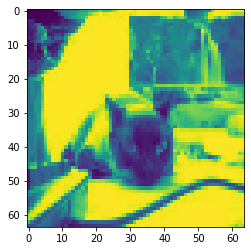

In [ ]:
plt.imshow(train_64_64_1[5,:,:,0])

In [ ]:
#normalize the data

X_train = train_64_64_1
X_test = test_64_64_1

X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

#remove standardization scaling as it is good to make the input values between 0 and 1

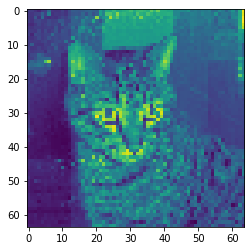

In [ ]:
plt.imshow(X_train[1,:,:,0])

In [ ]:
# Define the labels to be used 1000 cats = 0 1000 dogs = 1
df_train['label_n'] = np.where(df_train['label']=='cat', 0, 1)

y_train = df_train['label_n'].to_numpy()
y_train


array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
##create validation Dataset

x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(X_train
                                                                              ,y_train
                                                                              ,test_size=.2
                                                                              ,random_state=42
                                                                              ,shuffle=True)

In [ ]:
print(np.unique(y_train_split, return_counts=True))
print(np.unique(y_valid_split, return_counts=True))

(array([0, 1]), array([ 9985, 10015]))
(array([0, 1]), array([2515, 2485]))


In [ ]:
print(x_train_split.shape)
print(x_valid_split.shape)
print(X_test.shape)

(20000, 64, 64, 1)
(5000, 64, 64, 1)
(12500, 64, 64, 1)


In [ ]:
# define function for turning softmax result to class category
def class_output(result):
  pred_list = []
  for i in range(len(result)):
    pred = np.argmax(result[i])
    pred_list.append(pred)
  return np.array(pred_list).reshape((len(result), 1))

In [ ]:
##initiate list to track performance for each model


train_accuracy = []
val_accuracy = []
test_accuracy = []
recall = []
f1 = []
precision = []
train_time = []

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import mean_squared_error as MSE
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

In [ ]:
# define evaluation metrics tracking function

def score_track(model, x_train, y_train, x_val, y_val):
  result_dic = {}

  pred_trn = class_output(model.predict(x_train))
  ac_trn = accuracy_score(y_train, pred_trn)
  result_dic['accuracy_train'] = ac_trn

  pred_val = class_output(model.predict(x_val))
  ac_val = accuracy_score(y_val, pred_val)
  result_dic['accuracy_valid'] = ac_val
  f1_val = f1_score(y_val, pred_val, average = 'macro')
  result_dic['f1_val'] = f1_val
  recall_val = recall_score(y_val, pred_val, average = 'macro')
  result_dic['recall_val'] = recall_val
  precision_val = precision_score(y_val, pred_val, average = 'macro')
  result_dic['precision_val'] = precision_val

  #there is no test label dataset, since it is for competition

  return result_dic

#Experiment 1 - DNN with 3 layers (with no regularization)

---



In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Input, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import to_categorical

In [ ]:
#reshape the image for DNN training
width = 64
height = 64
channel = 1

x_train_flat = np.reshape(x_train_split, (20000, width*height*channel))
x_valid_flat = np.reshape(x_valid_split, (5000, width*height*channel))
x_test_flat = np.reshape(X_test, (12500, width*height*channel))

In [ ]:
print(x_train_flat.shape, x_valid_flat.shape, x_test_flat.shape)

(20000, 4096) (5000, 4096) (12500, 4096)


In [ ]:
model_1 = models.Sequential()
model_1.add(layers.Dense(input_shape = [width*height*channel], units=518, activation=tf.nn.relu))
model_1.add(layers.Dense(input_shape = [64*8], units=256, activation=tf.nn.relu))  #64*64 for the first hidden layer
model_1.add(layers.Dense(name = 'output_layer', units=2, activation=tf.nn.softmax))

In [ ]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 518)               2122246   
                                                                 
 dense_3 (Dense)             (None, 256)               132864    
                                                                 
 output_layer (Dense)        (None, 2)                 514       
                                                                 
Total params: 2,255,624
Trainable params: 2,255,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #set from_logits = False since Softmax has been applied in output layer
              metrics=['accuracy'])

In [ ]:
path = "/content/gdrive/MyDrive/458_AI/A4/"

In [ ]:
start_time = time.time()

history_1 = model_1.fit(
    x_train_flat,
    y_train_split,
    batch_size = 512,
    epochs = 100, 
    validation_data=(x_valid_flat, y_valid_split),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)]
)

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 3s 131us/sample - loss: 1.1644 - acc: 0.5023 - val_loss: 0.6859 - val_acc: 0.5608
Epoch 2/100
20000/20000 [==============================] - 3s 126us/sample - loss: 0.6845 - acc: 0.5552 - val_loss: 0.7368 - val_acc: 0.5150
Epoch 3/100
20000/20000 [==============================] - 3s 126us/sample - loss: 0.6990 - acc: 0.5410 - val_loss: 0.6802 - val_acc: 0.5770
Epoch 4/100
20000/20000 [==============================] - 3s 126us/sample - loss: 0.6750 - acc: 0.5793 - val_loss: 0.6684 - val_acc: 0.5932
Epoch 5/100
20000/20000 [==============================] - 3s 126us/sample - loss: 0.6680 - acc: 0.5892 - val_loss: 0.7249 - val_acc: 0.5480
Epoch 6/100
20000/20000 [==============================] - 3s 126us/sample - loss: 0.6645 - acc: 0.5990 - val_loss: 0.6646 - val_acc: 0.5994
Epoch 7/100
20000/20000 [==============================] - 3s 127us/sample - loss: 0.6561 - acc: 0.6068 -

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
model_1_score = score_track(model_1, x_train_flat, y_train_split, x_valid_flat, y_valid_split)

In [ ]:
model_1_score

{'accuracy_train': 0.6157,
 'accuracy_valid': 0.5922,
 'f1_val': 0.5806155789938221,
 'precision_val': 0.6052701668363966,
 'recall_val': 0.5932185558680113}

In [ ]:
model_1_score['train_time'] = train_time

In [ ]:
preds_1 = model_1.predict(x_test_flat)
print('shape of preds: ', preds_1.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_1.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
4,0.668,0.589,0.725,0.548
5,0.664,0.599,0.665,0.599
6,0.656,0.607,0.663,0.599
7,0.657,0.610,0.719,0.559
8,0.663,0.601,0.670,0.592


In [ ]:
losses = history_1.history['loss']
accs = history_1.history['acc']
val_losses = history_1.history['val_loss']
val_accs = history_1.history['val_acc']
epochs = len(losses)

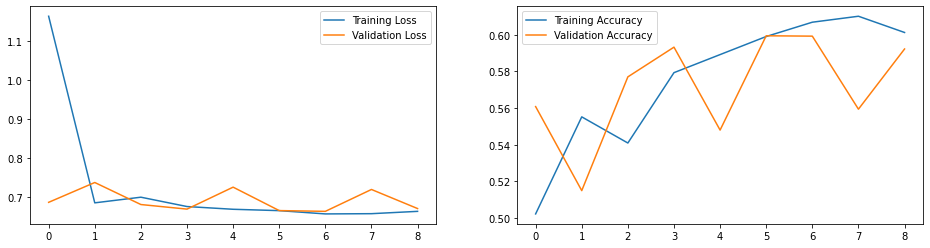

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred1_val= model_1.predict(x_valid_flat)
pred1_val=np.argmax(pred1_val, axis=1)

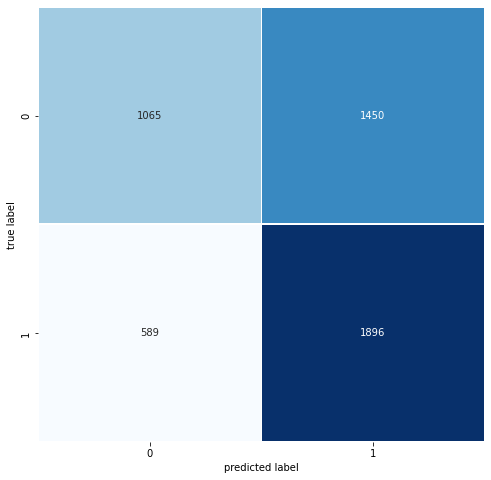

In [ ]:
plot_confusion_matrix(y_valid_split,pred1_val)

Findings:
significant overfitting has been identified from the training process, need to add more regularization to reduce overfitting

#Experiment 2 - DNN with 3 layers

Need to reduce overfitting

*   with L2 regularization
*   add dropout layer



In [ ]:
model_2 = models.Sequential()
model_2.add(layers.Dense(input_shape = [width*height*channel], units=518, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_2.add(layers.Dropout(0.3))
model_2.add(layers.Dense(input_shape = [518], units=256, activation=tf.nn.relu))  #64*64 for the first hidden layer
model_2.add(layers.Dense(name = 'output_layer', units=2, activation=tf.nn.softmax))

In [ ]:
model_2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 518)               2122246   
                                                                 
 dropout_1 (Dropout)         (None, 518)               0         
                                                                 
 dense_7 (Dense)             (None, 256)               132864    
                                                                 
 output_layer (Dense)        (None, 2)                 514       
                                                                 
Total params: 2,255,624
Trainable params: 2,255,624
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), #set from_logits = False since Softmax has been applied in output layer
              metrics=['accuracy'])

In [ ]:
path = "/content/gdrive/MyDrive/458_AI/A4/"

In [ ]:
start_time = time.time()

history_2 = model_2.fit(
    x_train_flat,
    y_train_split,
    batch_size = 512,
    epochs = 100, 
    validation_data=(x_valid_flat, y_valid_split),
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3)]
)

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 3s 151us/sample - loss: 1.7987 - acc: 0.5056 - val_loss: 1.2635 - val_acc: 0.5026
Epoch 2/100
20000/20000 [==============================] - 3s 145us/sample - loss: 1.1751 - acc: 0.5301 - val_loss: 1.1187 - val_acc: 0.5150
Epoch 3/100
20000/20000 [==============================] - 3s 145us/sample - loss: 1.0481 - acc: 0.5355 - val_loss: 0.9953 - val_acc: 0.5468
Epoch 4/100
20000/20000 [==============================] - 3s 143us/sample - loss: 0.9607 - acc: 0.5555 - val_loss: 0.9187 - val_acc: 0.5836
Epoch 5/100
20000/20000 [==============================] - 3s 145us/sample - loss: 0.8938 - acc: 0.5796 - val_loss: 0.8585 - val_acc: 0.6030
Epoch 6/100
20000/20000 [==============================] - 3s 146us/sample - loss: 0.8485 - acc: 0.5852 - val_loss: 0.8283 - val_acc: 0.5920
Epoch 7/100
20000/20000 [==============================] - 3s 145us/sample - loss: 0.8163 - acc: 0.5761 -

In [ ]:
#tracking training time
train_time = end_time - start_time

In [ ]:
model_2_score = score_track(model_2, x_train_flat, y_train_split, x_valid_flat, y_valid_split)

In [ ]:
model_2_score

{'accuracy_train': 0.61255,
 'accuracy_valid': 0.6024,
 'f1_val': 0.6022981883362141,
 'precision_val': 0.6026622442807414,
 'recall_val': 0.602517690636863}

In [ ]:
model_2_score['train_time'] = train_time

In [ ]:
preds_2 = model_2.predict(x_test_flat)
print('shape of preds: ', preds_2.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_2.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
3,0.961,0.556,0.919,0.584
4,0.894,0.580,0.859,0.603
5,0.848,0.585,0.828,0.592
6,0.816,0.576,0.799,0.595
7,0.784,0.582,0.768,0.602


In [ ]:
losses = history_2.history['loss']
accs = history_2.history['acc']
val_losses = history_2.history['val_loss']
val_accs = history_2.history['val_acc']
epochs = len(losses)

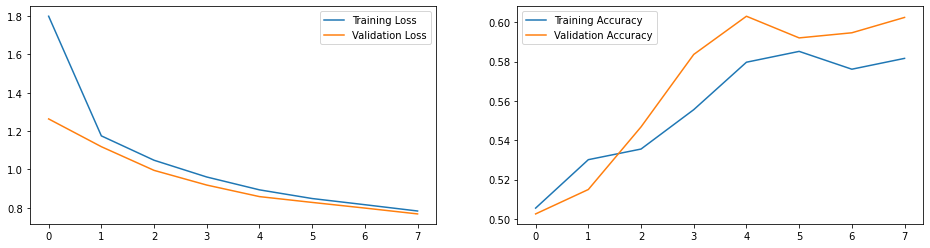

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred2_val= model_2.predict(x_valid_flat)
pred2_val=np.argmax(pred2_val, axis=1)

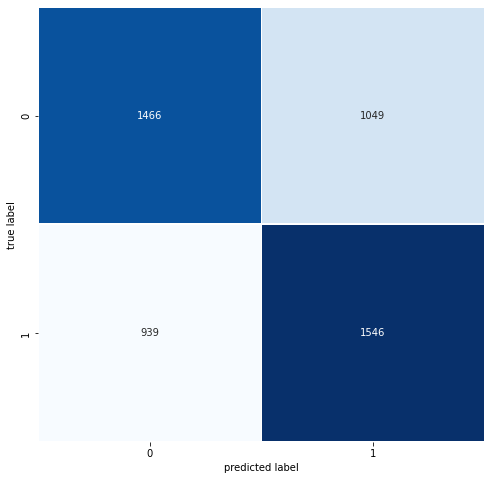

In [ ]:
plot_confusion_matrix(y_valid_split,pred2_val)

#Experiment 3 - CNN with 3 layers (no regularization)


1. 3 Conv Layer + Pooling Layers
2. no regularization
3. Without Dropout & Batch_Normalization layer


In [ ]:
model_3 = models.Sequential()
model_3.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(64, 64, 1)))
model_3.add(layers.MaxPool2D((2, 2),strides=2))
model_3.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_3.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_3.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_3.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_3.add(layers.Flatten())
model_3.add(layers.Dense(units=128, activation=tf.nn.relu))
model_3.add(layers.Dense(units=2, activation=tf.nn.softmax))

In [ ]:
model_3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 256)       

In [ ]:
model_3.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:

start_time = time.time()

history_3 = model_3.fit(x_train_split
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=64
                    ,validation_data=(x_valid_split, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 193s 10ms/sample - loss: 0.6537 - acc: 0.5952 - val_loss: 0.5755 - val_acc: 0.7064
Epoch 2/100
20000/20000 [==============================] - 194s 10ms/sample - loss: 0.5066 - acc: 0.7527 - val_loss: 0.4854 - val_acc: 0.7680
Epoch 3/100
20000/20000 [==============================] - 194s 10ms/sample - loss: 0.4343 - acc: 0.7997 - val_loss: 0.4401 - val_acc: 0.8008
Epoch 4/100
20000/20000 [==============================] - 202s 10ms/sample - loss: 0.3859 - acc: 0.8256 - val_loss: 0.4018 - val_acc: 0.8220
Epoch 5/100
20000/20000 [==============================] - 214s 11ms/sample - loss: 0.3414 - acc: 0.8500 - val_loss: 0.4096 - val_acc: 0.8244
Epoch 6/100
20000/20000 [==============================] - 206s 10ms/sample - loss: 0.2906 - acc: 0.8727 - val_loss: 0.3902 - val_acc: 0.8320
Epoch 7/100
20000/20000 [==============================] - 208s 10ms/sample - loss: 0.2421 - acc: 0

In [ ]:
train_time = end_time - start_time

In [ ]:
model_3_score = score_track(model_3, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [ ]:
model_3_score

{'accuracy_train': 0.9919,
 'accuracy_valid': 0.8318,
 'f1_val': 0.8316210535909142,
 'precision_val': 0.8327887046057094,
 'recall_val': 0.8316343388361981}

In [ ]:
model_3_score['train_time'] = train_time

In [ ]:
preds_3 = model_3.predict(X_test)
print('shape of preds: ', preds_3.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_3.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
12,0.059,0.978,0.582,0.827
13,0.037,0.988,0.832,0.826
14,0.037,0.986,0.697,0.836
15,0.034,0.989,0.786,0.828
16,0.029,0.989,0.853,0.832


In [ ]:
losses = history_3.history['loss']
accs = history_3.history['acc']
val_losses = history_3.history['val_loss']
val_accs = history_3.history['val_acc']
epochs = len(losses)

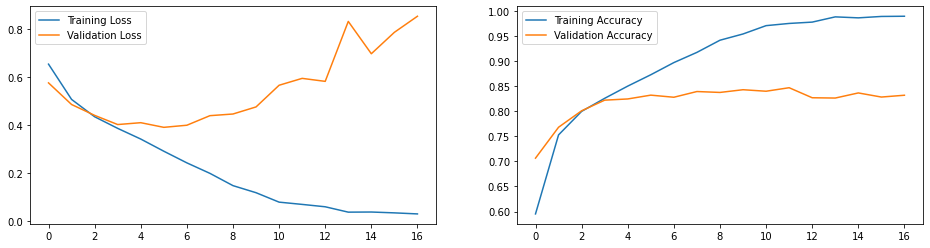

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred3_val= model_3.predict(x_valid_split)
pred3_val=np.argmax(pred3_val, axis=1)

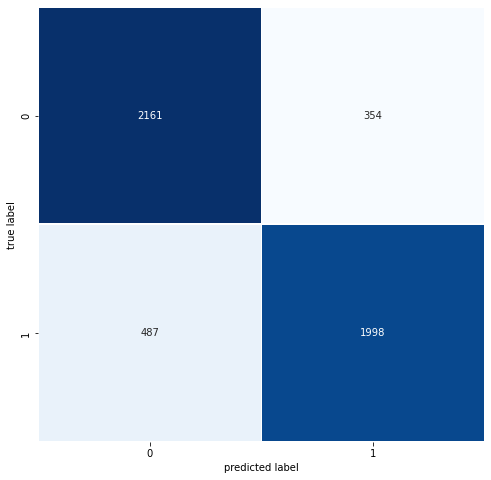

In [ ]:
plot_confusion_matrix(y_valid_split,pred3_val)

#Experiment 4 - CNN with 3 layers (with regularization)

We can tell significant overfitting from experiment 3, even though it has achieved quite high accuracy.

1. 3 Conv Layer + Pooling Layers
2. with L2 regularization
3. With Dropout & Batch_Normalization layer

In [ ]:
model_4 = models.Sequential()
model_4.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(64, 64, 1)))
model_4.add(layers.MaxPool2D((2, 2),strides=2))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_4.add(layers.Dropout(0.3))
model_4.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_4.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_4.add(layers.Flatten())
model_4.add(layers.BatchNormalization())
model_4.add(layers.Dense(units=128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_4.add(layers.Dense(units=2, activation=tf.nn.softmax))

In [ ]:
model_4.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 31, 31, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 14, 14, 128)      

In [ ]:
model_4.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:

start_time = time.time()

history_4 = model_4.fit(x_train_split
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=64
                    ,validation_data=(x_valid_split, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 238s 12ms/sample - loss: 0.7741 - acc: 0.6744 - val_loss: 0.7769 - val_acc: 0.5066
Epoch 2/100
20000/20000 [==============================] - 213s 11ms/sample - loss: 0.5786 - acc: 0.7537 - val_loss: 0.6861 - val_acc: 0.6224
Epoch 3/100
20000/20000 [==============================] - 244s 12ms/sample - loss: 0.5041 - acc: 0.7928 - val_loss: 0.5077 - val_acc: 0.7864
Epoch 4/100
20000/20000 [==============================] - 219s 11ms/sample - loss: 0.4593 - acc: 0.8156 - val_loss: 0.4666 - val_acc: 0.8146
Epoch 5/100
20000/20000 [==============================] - 218s 11ms/sample - loss: 0.4348 - acc: 0.8322 - val_loss: 0.5189 - val_acc: 0.8052
Epoch 6/100
20000/20000 [==============================] - 223s 11ms/sample - loss: 0.4105 - acc: 0.8485 - val_loss: 0.4648 - val_acc: 0.8270
Epoch 7/100
20000/20000 [==============================] - 220s 11ms/sample - loss: 0.3860 - acc: 0

In [ ]:
train_time = end_time - start_time

In [ ]:
model_4_score = score_track(model_4, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [ ]:
model_4_score

{'accuracy_train': 0.9107,
 'accuracy_valid': 0.7992,
 'f1_val': 0.7947774037984331,
 'precision_val': 0.8296920073285301,
 'recall_val': 0.800109603945742}

In [ ]:
model_4_score['train_time'] = train_time

In [ ]:
preds_4 = model_4.predict(X_test)
print('shape of preds: ', preds_4.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_4.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
14,0.294,0.927,0.571,0.840
15,0.285,0.932,0.618,0.828
16,0.278,0.937,0.724,0.805
17,0.279,0.936,0.549,0.849
18,0.262,0.944,0.685,0.799


In [ ]:
losses = history_4.history['loss']
accs = history_4.history['acc']
val_losses = history_4.history['val_loss']
val_accs = history_4.history['val_acc']
epochs = len(losses)

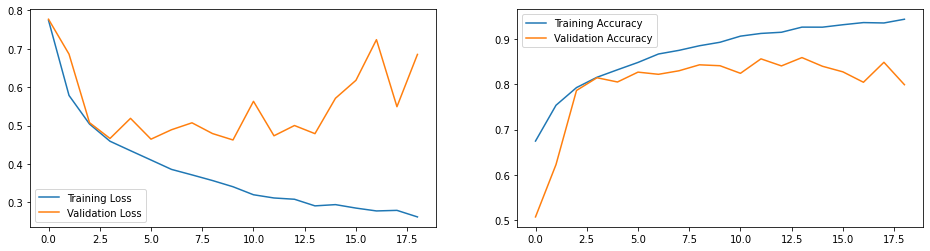

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred4_val= model_4.predict(x_valid_split)
pred4_val=np.argmax(pred4_val, axis=1)

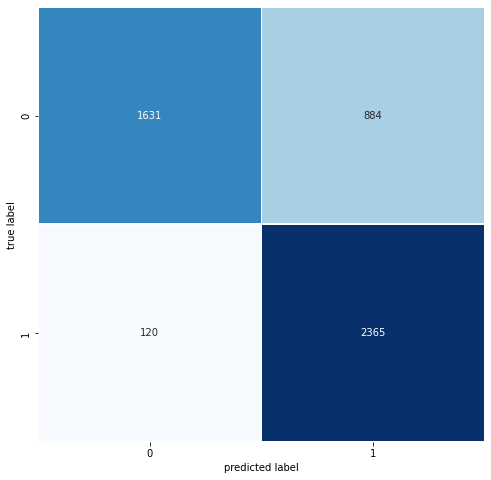

In [ ]:
plot_confusion_matrix(y_valid_split,pred4_val)

#Experiment 5 - CNN with 3 layers (with regularization)

Need to continue reduce overfitting problem,

- adding one more dropout layer before 1st dense layer
- remove dropout layer from Conv layers
- increaee dropout to 0.5 (In the original paper that proposed dropout layers, by Hinton (2012), dropout (with p=0.5) was used on each of the fully connected (dense) layers before the output; it was not used on the convolutional layers. This became the most commonly used configuration.)
More recent research has shown some value in applying dropout also to convolutional layers, although at much lower levels: p=0.1 or 0.2. Dropout was used after the activation function of each convolutional layer: CONV->RELU->DROP.

1. 3 Conv Layer + Pooling Layers
2. with L2 regularization
3. With Dropout & Batch_Normalization layer

In [ ]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(64, 64, 1)))
model_5.add(layers.MaxPool2D((2, 2),strides=2))
model_5.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_5.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_5.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_5.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_5.add(layers.Flatten())
model_5.add(layers.BatchNormalization())
model_5.add(layers.Dense(units=128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_5.add(layers.Dropout(0.5))
model_5.add(layers.Dense(units=2, activation=tf.nn.softmax))

In [ ]:
model_5.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 256)       295168    
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 6, 6, 256)       

In [ ]:
model_5.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:

start_time = time.time()

history_5 = model_5.fit(x_train_split
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=64
                    ,validation_data=(x_valid_split, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 236s 12ms/sample - loss: 0.7164 - acc: 0.6786 - val_loss: 0.7371 - val_acc: 0.5068
Epoch 2/100
20000/20000 [==============================] - 232s 12ms/sample - loss: 0.5535 - acc: 0.7671 - val_loss: 0.7470 - val_acc: 0.5970
Epoch 3/100
20000/20000 [==============================] - 209s 10ms/sample - loss: 0.4892 - acc: 0.7988 - val_loss: 0.5270 - val_acc: 0.7736
Epoch 4/100
20000/20000 [==============================] - 203s 10ms/sample - loss: 0.4536 - acc: 0.8229 - val_loss: 0.6057 - val_acc: 0.7470
Epoch 5/100
20000/20000 [==============================] - 208s 10ms/sample - loss: 0.4354 - acc: 0.8323 - val_loss: 0.7193 - val_acc: 0.7084
Epoch 6/100
20000/20000 [==============================] - 208s 10ms/sample - loss: 0.4077 - acc: 0.8519 - val_loss: 0.5673 - val_acc: 0.7866
Epoch 7/100
20000/20000 [==============================] - 204s 10ms/sample - loss: 0.3946 - acc: 0

In [ ]:
train_time = end_time - start_time

In [ ]:
model_5_score = score_track(model_5, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [ ]:
model_5_score

{'accuracy_train': 0.75805,
 'accuracy_valid': 0.713,
 'f1_val': 0.6924998111070269,
 'precision_val': 0.7951007005600783,
 'recall_val': 0.7145749246972891}

In [ ]:
model_5_score['train_time'] = train_time

In [ ]:
preds_5 = model_5.predict(X_test)
print('shape of preds: ', preds_4.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_5.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
7,0.375,0.878,1.189,0.614
8,0.356,0.887,0.571,0.810
9,0.349,0.891,1.069,0.706
10,0.320,0.909,1.068,0.728
11,0.333,0.906,1.241,0.713


In [ ]:
losses = history_5.history['loss']
accs = history_5.history['acc']
val_losses = history_5.history['val_loss']
val_accs = history_5.history['val_acc']
epochs = len(losses)

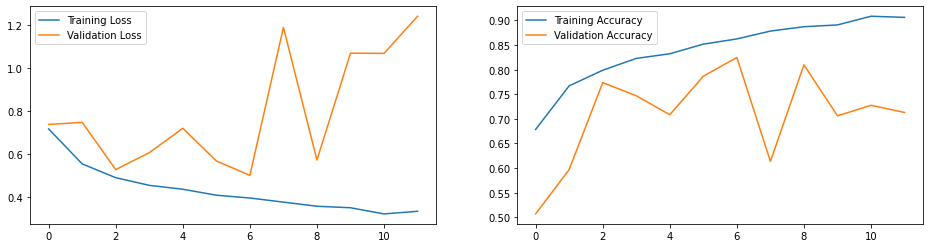

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred5_val= model_5.predict(x_valid_split)
pred5_val=np.argmax(pred5_val, axis=1)

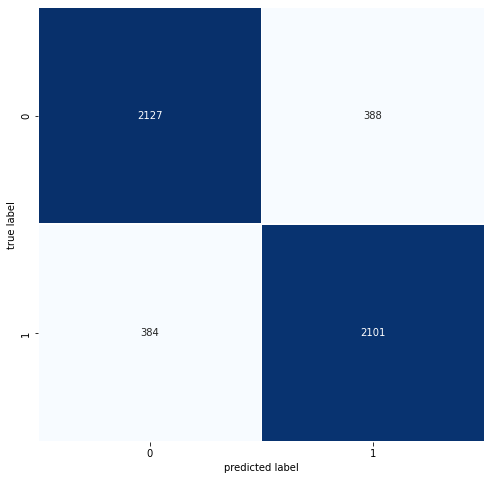

In [ ]:
plot_confusion_matrix(y_valid_split,pred4_val)

#Experiment 6 - CNN with 3 layers (with regularization)


1. 3 Conv Layer + Pooling Layers
2. with L2 regularization
3. With Dropout & Batch_Normalization layer
- adding dropout (0.1) after conv layers
- adding dropout (0.5) after dense layers

In [ ]:
model_6 = models.Sequential()
model_6.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(64, 64, 1)))
model_6.add(layers.MaxPool2D((2, 2),strides=2))
model_6.add(layers.Dropout(0.1))
model_6.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_6.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_6.add(layers.Dropout(0.1))
model_6.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_6.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_6.add(layers.Flatten())
model_6.add(layers.BatchNormalization())
model_6.add(layers.Dense(units=128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_6.add(layers.Dropout(0.5))
model_6.add(layers.Dense(units=2, activation=tf.nn.softmax))

In [ ]:
model_6.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 31, 31, 64)        0         
                                                                 
 conv2d_16 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 14, 14, 128)      

In [ ]:
model_6.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:

start_time = time.time()

history_6 = model_6.fit(x_train_split
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=64
                    ,validation_data=(x_valid_split, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 231s 12ms/sample - loss: 0.7881 - acc: 0.6464 - val_loss: 0.7589 - val_acc: 0.5902
Epoch 2/100
20000/20000 [==============================] - 226s 11ms/sample - loss: 0.6023 - acc: 0.7420 - val_loss: 0.6929 - val_acc: 0.6194
Epoch 3/100
20000/20000 [==============================] - 224s 11ms/sample - loss: 0.5322 - acc: 0.7811 - val_loss: 0.5629 - val_acc: 0.7738
Epoch 4/100
20000/20000 [==============================] - 221s 11ms/sample - loss: 0.4937 - acc: 0.8070 - val_loss: 0.5513 - val_acc: 0.7842
Epoch 5/100
20000/20000 [==============================] - 218s 11ms/sample - loss: 0.4560 - acc: 0.8278 - val_loss: 0.5795 - val_acc: 0.7596
Epoch 6/100
20000/20000 [==============================] - 212s 11ms/sample - loss: 0.4429 - acc: 0.8443 - val_loss: 0.6066 - val_acc: 0.7990
Epoch 7/100
20000/20000 [==============================] - 213s 11ms/sample - loss: 0.4140 - acc: 0

In [ ]:
train_time = end_time - start_time

In [ ]:
model_6_score = score_track(model_6, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [ ]:
model_6_score

{'accuracy_train': 0.9817,
 'accuracy_valid': 0.8668,
 'f1_val': 0.866767576557431,
 'precision_val': 0.8669574326480287,
 'recall_val': 0.8667376025536919}

In [ ]:
model_6_score['train_time'] = train_time

In [ ]:
preds_6 = model_6.predict(X_test)
print('shape of preds: ', preds_6.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_6.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
17,0.308,0.928,0.527,0.856
18,0.304,0.932,0.629,0.841
19,0.307,0.933,0.532,0.865
20,0.286,0.939,0.542,0.862
21,0.289,0.937,0.487,0.867


In [ ]:
losses = history_6.history['loss']
accs = history_6.history['acc']
val_losses = history_6.history['val_loss']
val_accs = history_6.history['val_acc']
epochs = len(losses)

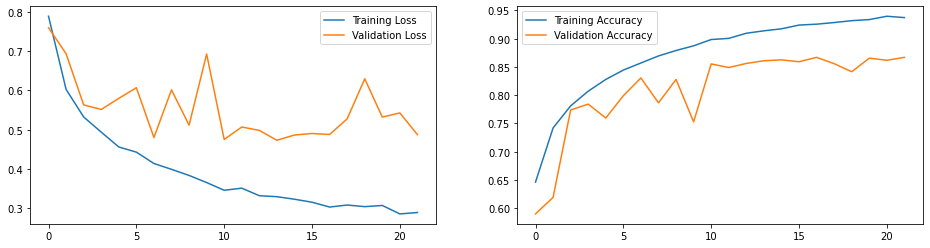

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred6_val= model_6.predict(x_valid_split)
pred6_val=np.argmax(pred6_val, axis=1)

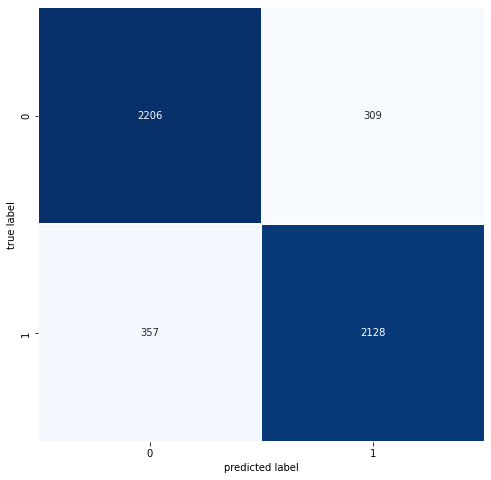

In [ ]:
plot_confusion_matrix(y_valid_split,pred6_val)

#Experiment 7 - CNN with 3 layers (with regularization)


1. 3 Conv Layer + Pooling Layers
2. with L2 regularization
3. With Dropout & Batch_Normalization layer
- adding dropout (0.1) after conv layers
- adding dropout (0.5) after dense layers
4. use keras.optimizers.RMSprop(lr=1e-4, rho=0.9) as optimizer

In [ ]:
model_7 = models.Sequential()
model_7.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu,input_shape=(64, 64, 1)))
model_7.add(layers.MaxPool2D((2, 2),strides=2))
model_7.add(layers.Dropout(0.1))
model_7.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_7.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_7.add(layers.Dropout(0.1))
model_7.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu))
model_7.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_7.add(layers.Flatten())
model_7.add(layers.BatchNormalization())
model_7.add(layers.Dense(units=128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_7.add(layers.Dropout(0.5))
model_7.add(layers.Dense(units=2, activation=tf.nn.softmax))

In [ ]:
model_7.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 31, 31, 64)       0         
 g2D)                                                            
                                                                 
 dropout_10 (Dropout)        (None, 31, 31, 64)        0         
                                                                 
 conv2d_19 (Conv2D)          (None, 29, 29, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 14, 14, 128)      0         
 g2D)                                                            
                                                                 
 dropout_11 (Dropout)        (None, 14, 14, 128)     

In [ ]:
model_7.compile(optimizer=keras.optimizers.RMSprop(lr=1e-4, rho=0.9),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:

start_time = time.time()

history_7 = model_7.fit(x_train_split
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=64
                    ,validation_data=(x_valid_split, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 247s 12ms/sample - loss: 0.8779 - acc: 0.6234 - val_loss: 0.8694 - val_acc: 0.5894
Epoch 2/100
20000/20000 [==============================] - 221s 11ms/sample - loss: 0.7402 - acc: 0.7068 - val_loss: 0.7374 - val_acc: 0.7082
Epoch 3/100
20000/20000 [==============================] - 223s 11ms/sample - loss: 0.6582 - acc: 0.7521 - val_loss: 0.7143 - val_acc: 0.7150
Epoch 4/100
20000/20000 [==============================] - 221s 11ms/sample - loss: 0.6037 - acc: 0.7811 - val_loss: 0.6381 - val_acc: 0.7530
Epoch 5/100
20000/20000 [==============================] - 219s 11ms/sample - loss: 0.5604 - acc: 0.7997 - val_loss: 0.5702 - val_acc: 0.7922
Epoch 6/100
20000/20000 [==============================] - 239s 12ms/sample - loss: 0.5208 - acc: 0.8169 - val_loss: 0.6532 - val_acc: 0.7640
Epoch 7/100
20000/20000 [==============================] - 249s 12ms/sample - loss: 0.4900 - acc: 0

In [ ]:
train_time = end_time - start_time

In [ ]:
model_7_score = score_track(model_7, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [ ]:
model_7_score

{'accuracy_train': 0.97545,
 'accuracy_valid': 0.8366,
 'f1_val': 0.8361603789752816,
 'precision_val': 0.839541591712673,
 'recall_val': 0.8363193074950699}

In [ ]:
model_7_score['train_time'] = train_time

In [ ]:
preds_7 = model_7.predict(X_test)
print('shape of preds: ', preds_7.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_7.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
16,0.244,0.939,0.633,0.796
17,0.226,0.947,0.653,0.807
18,0.211,0.952,0.522,0.833
19,0.202,0.957,0.534,0.824
20,0.188,0.962,0.612,0.837


In [ ]:
losses = history_7.history['loss']
accs = history_7.history['acc']
val_losses = history_7.history['val_loss']
val_accs = history_7.history['val_acc']
epochs = len(losses)

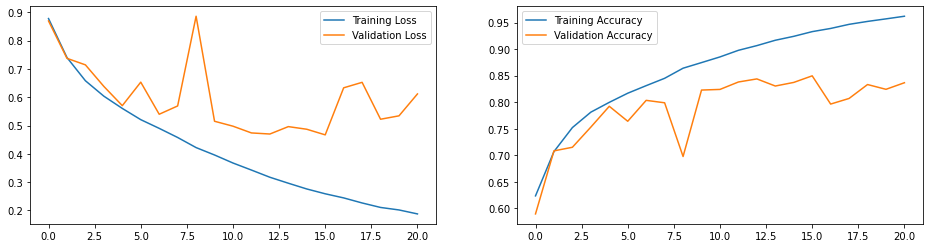

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred7_val= model_7.predict(x_valid_split)
pred7_val=np.argmax(pred7_val, axis=1)

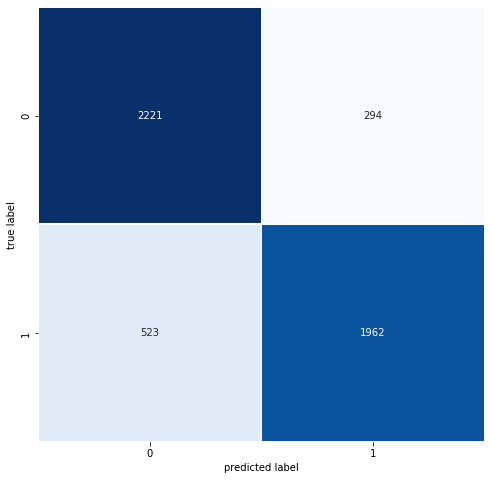

In [ ]:
plot_confusion_matrix(y_valid_split,pred7_val)

#Experiment 8 - CNN with 3 layers (with regularization)


1. 3 Conv Layer + Pooling Layers 
- use "padding = same" for all conv layers
2. with L2 regularization
3. With Dropout & Batch_Normalization layer
- adding dropout (0.1) after conv layers
- adding dropout (0.5) after dense layers
4. use keras.optimizers.RMSprop(lr=1e-4, rho=0.9) as optimizer

In [ ]:
model_8 = models.Sequential()
model_8.add(layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu,input_shape=(64, 64, 1)))
model_8.add(layers.MaxPool2D((2, 2),strides=2))
model_8.add(layers.Dropout(0.1))
model_8.add(layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_8.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_8.add(layers.Dropout(0.1))
model_8.add(layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), padding = 'same', activation=tf.nn.relu))
model_8.add(layers.MaxPool2D(pool_size=(2, 2),strides=2))
model_8.add(layers.Flatten())
model_8.add(layers.BatchNormalization())
model_8.add(layers.Dense(units=128, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.001)))
model_8.add(layers.Dropout(0.5))
model_8.add(layers.Dense(units=2, activation=tf.nn.softmax))

In [ ]:
model_8.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 dropout_14 (Dropout)        (None, 16, 16, 128)     

In [ ]:
model_8.compile(optimizer= 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [ ]:

start_time = time.time()

history_8 = model_8.fit(x_train_split
                    ,y_train_split
                    ,epochs=100
                    ,batch_size=64
                    ,validation_data=(x_valid_split, y_valid_split)
                    ,callbacks=[
                    tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=5)]                                                                                                         
                   )

end_time = time.time()

Train on 20000 samples, validate on 5000 samples
Epoch 1/100
20000/20000 [==============================] - 297s 15ms/sample - loss: 0.7486 - acc: 0.6945 - val_loss: 0.7585 - val_acc: 0.7086
Epoch 2/100
20000/20000 [==============================] - 303s 15ms/sample - loss: 0.5880 - acc: 0.7657 - val_loss: 0.5742 - val_acc: 0.7614
Epoch 3/100
20000/20000 [==============================] - 305s 15ms/sample - loss: 0.5285 - acc: 0.7944 - val_loss: 0.5770 - val_acc: 0.7730
Epoch 4/100
20000/20000 [==============================] - 280s 14ms/sample - loss: 0.4877 - acc: 0.8183 - val_loss: 0.5194 - val_acc: 0.8054
Epoch 5/100
20000/20000 [==============================] - 276s 14ms/sample - loss: 0.4593 - acc: 0.8368 - val_loss: 0.5991 - val_acc: 0.7716
Epoch 6/100
20000/20000 [==============================] - 274s 14ms/sample - loss: 0.4467 - acc: 0.8507 - val_loss: 0.7685 - val_acc: 0.7502
Epoch 7/100
20000/20000 [==============================] - 276s 14ms/sample - loss: 0.4284 - acc: 0

In [ ]:
train_time = end_time - start_time

In [ ]:
model_8_score = score_track(model_8, x_train_split, y_train_split, x_valid_split, y_valid_split)

In [ ]:
model_8_score

{'accuracy_train': 0.7437,
 'accuracy_valid': 0.704,
 'f1_val': 0.6797455136674229,
 'precision_val': 0.797890394216243,
 'recall_val': 0.7056766043577569}

In [ ]:
model_8_score['train_time'] = train_time

In [ ]:
preds_8 = model_8.predict(X_test)
print('shape of preds: ', preds_7.shape)

shape of preds:  (12500, 2)


In [ ]:
history_dict = history_8.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,acc,val_loss,val_acc
4,0.459,0.837,0.599,0.772
5,0.447,0.851,0.768,0.750
6,0.428,0.863,0.561,0.802
7,0.415,0.875,0.684,0.792
8,0.406,0.878,0.959,0.704


In [ ]:
losses = history_8.history['loss']
accs = history_8.history['acc']
val_losses = history_8.history['val_loss']
val_accs = history_8.history['val_acc']
epochs = len(losses)

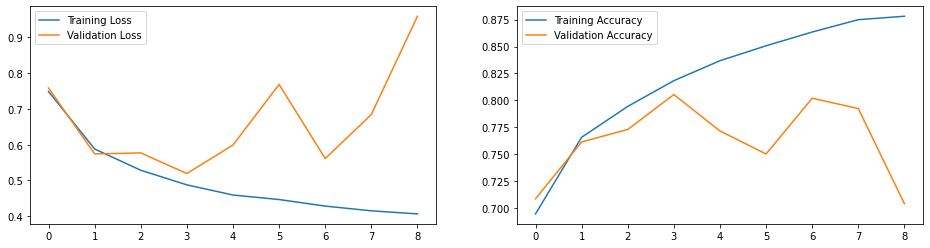

In [ ]:
plt.figure(figsize=(16, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [ ]:
#confusion matrix generation

pred8_val= model_8.predict(x_valid_split)
pred8_val=np.argmax(pred8_val, axis=1)

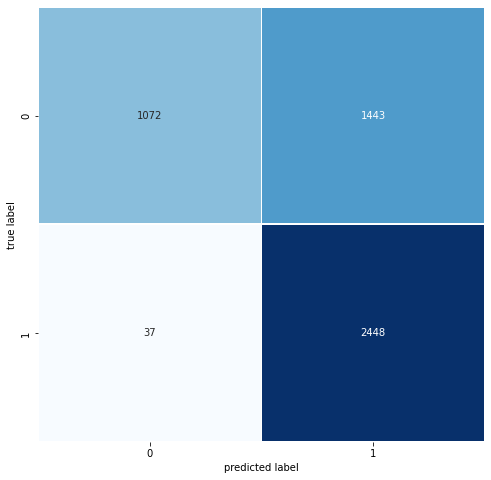

In [ ]:
plot_confusion_matrix(y_valid_split,pred8_val)

#Result Summary - Baseline Models

In [ ]:
score = [model_1_score, model_2_score, model_3_score, model_4_score, model_5_score, model_6_score, model_7_score, model_8_score]

In [ ]:
Perf_table = pd.DataFrame(score, index =['model1', 'model2', 'model3','model4','model5','model6','model7','model8'])

description = ['DNN-3 layer (Adam Optimizer)-no regularization',
               'DNN-3 layer (Adam Optimizer)-with L2 regularization / Dropout(0.3) ',
               'CNN-3 layer (Adam Optimizer)-no regularization',
               'CNN-3 layer (Adam Optimizer)-with L2 regularization / Dropout(0.3)-Conv / BatchNormalization',
               'CNN-3 layer (Adam Optimizer)-with L2 regularization / Dropout(0.5)-Dense / BatchNormalization',
               'CNN-3 layer (Adam Optimizer)-with L2 regularization / Dropout(0.1)-Conv / Dropout(0.5)-Dense / BatchNormalization',
               'CNN-3 layer (RMSprop Optimizer)-with L2 regularization / Dropout(0.1)-Conv / Dropout(0.5)-Dense / BatchNormalization',
               'CNN-3 layer (Same Padding, Adam Optimizer)-with L2 regularization / Dropout(0.1)-Conv / Dropout(0.5)-Dense / BatchNormalization',
]

Perf_table.insert(0, 'Description', description)

print

,Description,accuracy_train,accuracy_valid,f1_val,recall_val,precision_val,train_time
model1,DNN-3 layer (Adam Optimizer)-no regularization,0.61570,0.5922,0.580616,0.593219,0.605270,23.153266
model2,DNN-3 layer (Adam Optimizer)-with L2 regulariz...,0.61255,0.6024,0.602298,0.602518,0.602662,23.671993
model3,CNN-3 layer (Adam Optimizer)-no regularization,0.99190,0.8318,0.831621,0.831634,0.832789,3379.880623
model4,CNN-3 layer (Adam Optimizer)-with L2 regulariz...,0.91070,0.7992,0.794777,0.800110,0.829692,4238.568562
model5,CNN-3 layer (Adam Optimizer)-with L2 regulariz...,0.75805,0.7130,0.692500,0.714575,0.795101,2536.938587
model6,CNN-3 layer (Adam Optimizer)-with L2 regulariz...,0.98170,0.8668,0.866768,0.866738,0.866957,4846.752399
model7,CNN-3 layer (RMSprop Optimizer)-with L2 regula...,0.97545,0.8366,0.836160,0.836319,0.839542,4828.656311
model8,"CNN-3 layer (Same Padding, Adam Optimizer)-wit...",0.74370,0.7040,0.679746,0.705677,0.797890,2562.545241


In [ ]:
%%shell
jupyter nbconvert --to html /content/gdrive/MyDrive/458_AI/A4/A4_Part1.ipynb

[NbConvertApp] Converting notebook /content/gdrive/MyDrive/458_AI/A4/A4_Part1.ipynb to html
[NbConvertApp] Writing 1168286 bytes to /content/gdrive/MyDrive/458_AI/A4/A4_Part1.html
